In [1]:
%matplotlib inline 
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
TRAIN_DATASET_DIR="../dataset/"
TRAIN_FILE = 'train.tfrecords'
VALIDATION_FILE = 'validation.tfrecords'

In [3]:
def parser(record):
    keys_to_features = {
        "image_raw": tf.FixedLenFeature((), tf.string, default_value=""),
        'annotation_raw': tf.FixedLenFeature([], tf.string),
        "height": tf.FixedLenFeature((), tf.int64),
        "width": tf.FixedLenFeature((), tf.int64)
    }
    
    features = tf.parse_single_example(record, keys_to_features)
    
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['annotation_raw'], tf.uint8)

    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image = tf.reshape(image, (height,width,3), name="image_reshape")
    annotation = tf.reshape(annotation, (height,width), name="annotation_reshape")
    
    return image, annotation

In [4]:
def random_flip_image_and_annotation(image_tensor, annotation_tensor):
    """Accepts image tensor and annotation tensor and returns randomly flipped tensors of both.
    The function performs random flip of image and annotation tensors with probability of 1/2
    The flip is performed or not performed for image and annotation consistently, so that
    annotation matches the image.

    Parameters
    ----------
    image_tensor : Tensor of size (width, height, 3)
        Tensor with image
    annotation_tensor : Tensor of size (width, height, 1)
        Tensor with annotation

    Returns
    -------
    randomly_flipped_img : Tensor of size (width, height, 3) of type tf.float.
        Randomly flipped image tensor
    randomly_flipped_annotation : Tensor of size (width, height, 1)
        Randomly flipped annotation tensor

    """
    annotation_tensor = tf.expand_dims(annotation_tensor, axis=2)

    # Random variable: two possible outcomes (0 or 1)
    # with a 1 in 2 chance
    random_var = tf.random_uniform(maxval=2, dtype=tf.int32, shape=[])


    randomly_flipped_img = tf.cond(pred=tf.equal(random_var, 0),
                                                 true_fn=lambda: tf.image.flip_left_right(image_tensor),
                                                 false_fn=lambda: image_tensor)

    randomly_flipped_annotation = tf.cond(pred=tf.equal(random_var, 0),
                                                        true_fn=lambda: tf.image.flip_left_right(annotation_tensor),
                                                        false_fn=lambda: annotation_tensor)

    return randomly_flipped_img, tf.squeeze(randomly_flipped_annotation)

In [5]:
def cutout(image, label):
    cutout_shape = [24,24]
    
    def random_cutout(image):
        center_x = np.random.randint(0, image.shape[0])
        center_y = np.random.randint(0, image.shape[0])

        # check boundaries conditions
        from_x = center_x-cutout_shape[0]//2 if center_x-cutout_shape[0]//2 > 0 else 0
        to_x = image.shape[0] if (center_x+cutout_shape[0]//2) > image.shape[0] else center_x+cutout_shape[0]//2

        from_y = center_y-cutout_shape[0]//2 if center_y-cutout_shape[0]//2 > 0 else 0
        to_y = image.shape[1] if (center_y+cutout_shape[0]//2) > image.shape[1] else center_y+cutout_shape[1]//2

        image[from_x:to_x,from_y:to_y] = 0
        return image
    
    return tf.py_func(random_cutout, [image], (image.dtype)), label

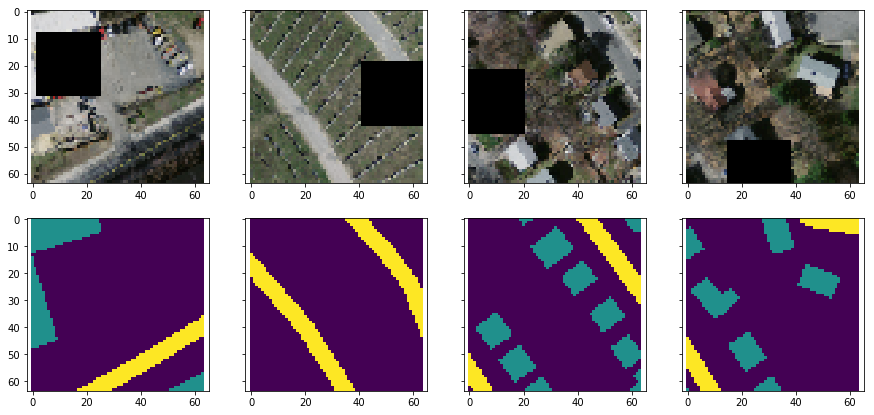

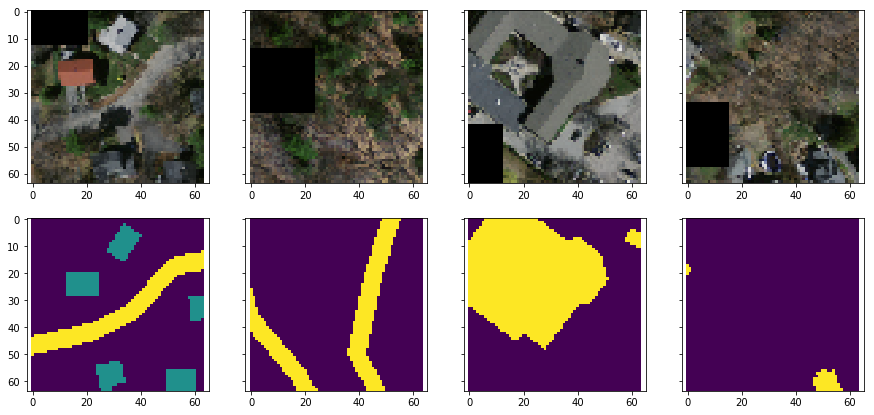

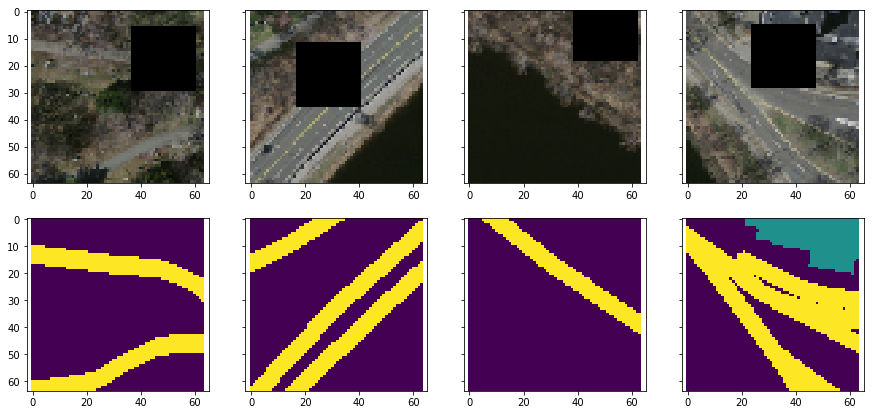

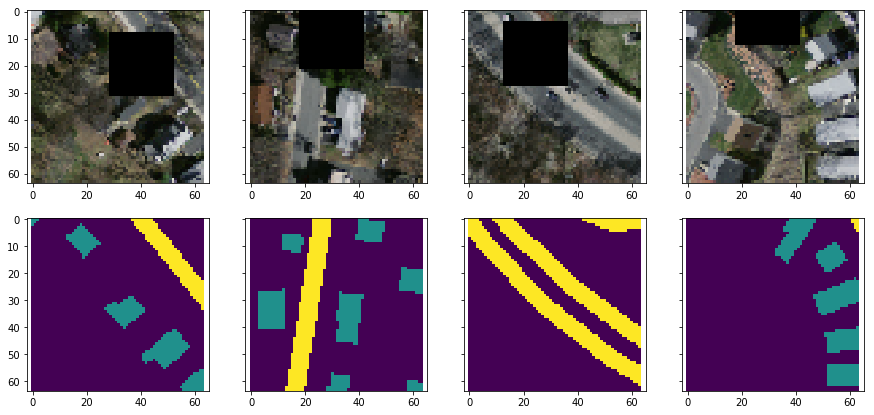

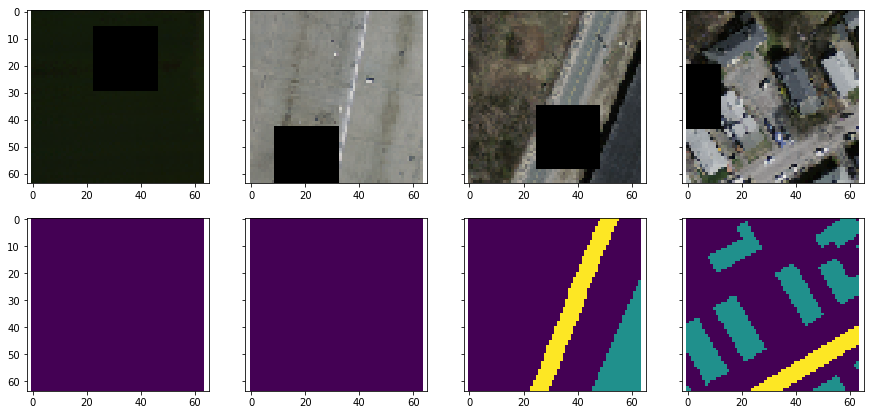

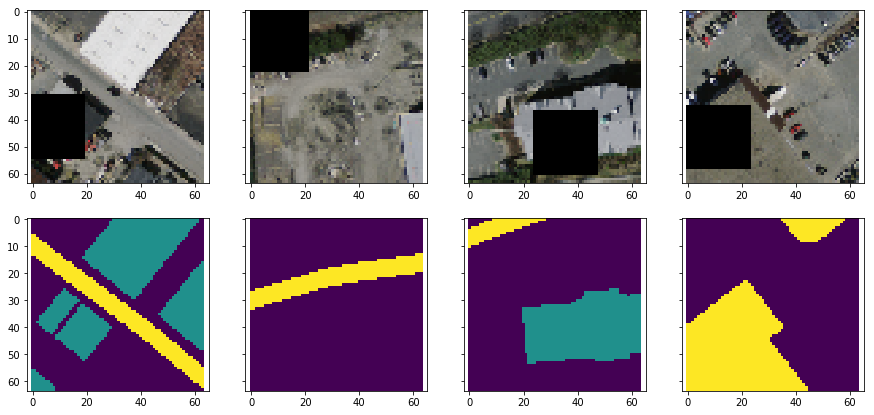

KeyboardInterrupt: 

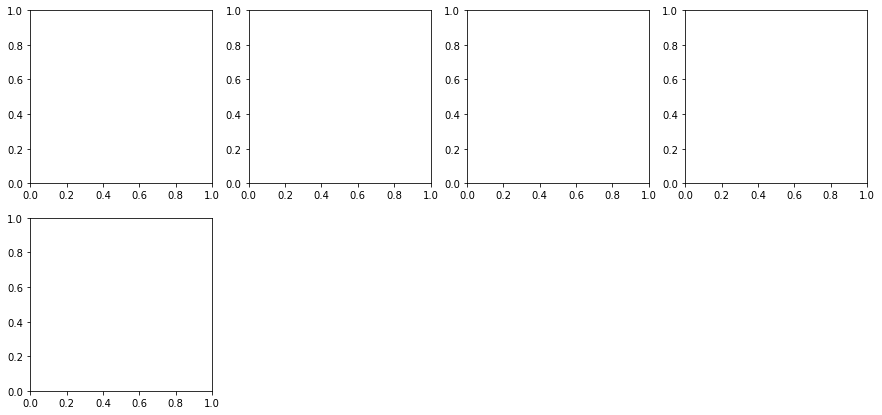

In [6]:
training_filenames = [os.path.join(TRAIN_DATASET_DIR,TRAIN_FILE)]
training_dataset = tf.contrib.data.TFRecordDataset(training_filenames)
training_dataset = training_dataset.map(parser)  # Parse the record into tensors.
training_dataset = training_dataset.map(random_flip_image_and_annotation)  

training_dataset = training_dataset.map(cutout)

#training_dataset = training_dataset.map(
#    lambda image, label: tf.py_func(
#        cutout, [(image)], (image.dtype)), label)

training_dataset = training_dataset.repeat()  # number of epochs
training_dataset = training_dataset.batch(64)
training_dataset = training_dataset.shuffle(buffer_size=1000)

validation_filenames = [os.path.join(TRAIN_DATASET_DIR,VALIDATION_FILE)]
validation_dataset = tf.contrib.data.TFRecordDataset(validation_filenames)
validation_dataset = validation_dataset.map(parser)  # Parse the record into tensors.
validation_dataset = validation_dataset.batch(1)

# A feedable iterator is defined by a handle placeholder and its structure. We
# could use the `output_types` and `output_shapes` properties of either
# `training_dataset` or `validation_dataset` here, because they have
# identical structure.
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.contrib.data.Iterator.from_string_handle(
    handle, training_dataset.output_types, training_dataset.output_shapes)
next_element = iterator.get_next()

# You can use feedable iterators with a variety of different kinds of iterator
# (such as one-shot and initializable iterators).
training_iterator = training_dataset.make_initializable_iterator()
validation_iterator = validation_dataset.make_initializable_iterator()

counter = 0

with tf.Session() as sess:
    sess.run(training_iterator.initializer)
    # The `Iterator.string_handle()` method returns a tensor that can be evaluated
    # and used to feed the `handle` placeholder.
    training_handle = sess.run(training_iterator.string_handle())
    validation_handle = sess.run(validation_iterator.string_handle())
    #sess.run(training_iterator.initializer)
    
    while True:
        for i in range(8):
            image_batch, annotation_batch = sess.run(next_element, feed_dict={handle: training_handle})
            f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, sharey=True, figsize=(15,7))
            idx = random.sample(range(32), 8)
            ax1.imshow(image_batch[idx[0]])
            ax2.imshow(image_batch[idx[1]])
            ax3.imshow(image_batch[idx[2]])
            ax4.imshow(image_batch[idx[3]])
            ax5.imshow(annotation_batch[idx[0]])
            ax6.imshow(annotation_batch[idx[1]])
            ax7.imshow(annotation_batch[idx[2]])
            ax8.imshow(annotation_batch[idx[3]])
            plt.show()
            counter+=1
        
        print("End of epoch:", i)

        # Initialize `iterator` with validation data.
        sess.run(validation_iterator.initializer)
        for i in range(4):
            try:
                image_batch, annotation_batch = sess.run(next_element, feed_dict={handle: validation_handle})
                print(annotation_batch.shape)
                f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,7))
                ax1.imshow(image_batch[0])
                ax2.imshow(annotation_batch[0])
                plt.show()
            except tf.errors.OutOfRangeError:
                print("End of validation")
                break


In [6]:
training_filenames = [os.path.join(TRAIN_DATASET_DIR,TRAIN_FILE)]
training_dataset = tf.contrib.data.TFRecordDataset(training_filenames)
training_dataset = training_dataset.map(parser)  # Parse the record into tensors.
#training_dataset = training_dataset.map(random_flip_image_and_annotation)  
#training_dataset = training_dataset.map(cutout)

training_dataset = training_dataset.repeat(1)  # number of epochs
training_dataset = training_dataset.batch(1)
#training_dataset = training_dataset.shuffle(buffer_size=1000)

validation_filenames = [os.path.join(TRAIN_DATASET_DIR,VALIDATION_FILE)]
validation_dataset = tf.contrib.data.TFRecordDataset(validation_filenames)
validation_dataset = validation_dataset.map(parser)  # Parse the record into tensors.
validation_dataset = validation_dataset.batch(1)

# A feedable iterator is defined by a handle placeholder and its structure. We
# could use the `output_types` and `output_shapes` properties of either
# `training_dataset` or `validation_dataset` here, because they have
# identical structure.
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.contrib.data.Iterator.from_string_handle(
    handle, training_dataset.output_types, training_dataset.output_shapes)
next_element = iterator.get_next()

# You can use feedable iterators with a variety of different kinds of iterator
# (such as one-shot and initializable iterators).
training_iterator = training_dataset.make_initializable_iterator()
validation_iterator = validation_dataset.make_initializable_iterator()

counter = 0

# get the total number of images in the tf record training set
number_of_images = 0
for fn in training_filenames:
    for record in tf.python_io.tf_record_iterator(fn):
        number_of_images += 1

r_mean, g_mean, b_mean = 0.,0.,0.

total_number_of_pixels_class_0 = 0.
total_number_of_pixels_class_1 = 0.
total_number_of_pixels_class_2 = 0.

r_std, g_std, b_std = 0.,0.,0.

total_number_of_pixels_where_class_0_is_present = 0
total_number_of_pixels_where_class_1_is_present = 0
total_number_of_pixels_where_class_2_is_present = 0

with tf.Session() as sess:
    sess.run(training_iterator.initializer)
    # The `Iterator.string_handle()` method returns a tensor that can be evaluated
    # and used to feed the `handle` placeholder.
    training_handle = sess.run(training_iterator.string_handle())
    validation_handle = sess.run(validation_iterator.string_handle())
    #sess.run(training_iterator.initializer)
    
    while True:
        try:
            image_batch, annotation_batch = sess.run(next_element, feed_dict={handle: training_handle})
            image = np.squeeze(image_batch)
            annotation = np.squeeze(annotation_batch)
            
            if counter == 0:
                image_height = image.shape[0]
                image_width = image.shape[1]
                print(image_height, image_width)
                
            # get the mean values for each of the channels
            r_mean += np.mean(image[:,:,0]) # R
            g_mean += np.mean(image[:,:,1]) # G
            b_mean += np.mean(image[:,:,2]) # B

            r_std += np.std(image[:,:,0])
            g_std += np.std(image[:,:,1])
            b_std += np.std(image[:,:,2])

            cnt_class_0 = 0
            cnt_class_1 = 0
            cnt_class_2 = 0

            for i in range(64):
                for j in range(64):
                    if (annotation[i,j] == 0):
                        cnt_class_0 += 1
                    elif (annotation[i,j] == 1):
                        cnt_class_1 += 1
                    elif (annotation[i,j] == 2):
                        cnt_class_2 += 1
                        
            if cnt_class_0 > 0:
                total_number_of_pixels_where_class_0_is_present += 64*64
            if cnt_class_1 > 0:
                total_number_of_pixels_where_class_1_is_present += 64*64
            if cnt_class_2 > 0:
                total_number_of_pixels_where_class_2_is_present += 64*64
                
            total_number_of_pixels_class_0 += cnt_class_0
            total_number_of_pixels_class_1 += cnt_class_1
            total_number_of_pixels_class_2 += cnt_class_2
            
            counter+=1
        except tf.errors.OutOfRangeError:
            print("End of dataset")
            break

64 64
End of dataset


In [54]:
print(counter)

561152


[2293424128, 1868853248, 1981321216]


<Container object of 3 artists>

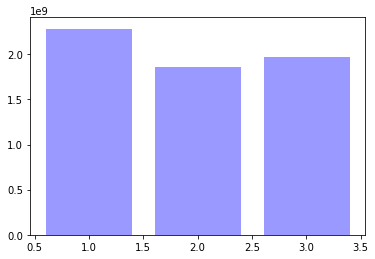

In [46]:
total_number_of_pixels_where_class_c_is_present = [total_number_of_pixels_where_class_0_is_present, total_number_of_pixels_where_class_1_is_present, total_number_of_pixels_where_class_2_is_present]
print(total_number_of_pixels_where_class_c_is_present)
plt.bar([1,2,3], total_number_of_pixels_where_class_c_is_present, facecolor='#9999ff', edgecolor='white')

In [7]:
size = sum(1 for _ in tf.python_io.tf_record_iterator(training_filenames[0]))

In [8]:
print("Size:", size)

Size: 561152


In [9]:
print("R Mean:", r_mean/size)
print("G Mean:", g_mean/size)
print("B Mean:", b_mean/size)

print("R Std:", r_std/size)
print("G Std:", g_std/size)
print("B Std:", b_std/size)

R Mean: 84.7362072189
G Mean: 86.0941014747
B Mean: 78.4789828349
R Std: 43.0708766207
G Std: 41.7703955642
B Std: 42.0244728104


In [11]:
total_number_of_pixels_per_class = [total_number_of_pixels_class_0, total_number_of_pixels_class_1, total_number_of_pixels_class_2]
print(total_number_of_pixels_per_class)
print(np.sort(total_number_of_pixels_per_class))

[1672943358.0, 363715747.0, 261819487.0]
[  2.61819487e+08   3.63715747e+08   1.67294336e+09]


<Container object of 3 artists>

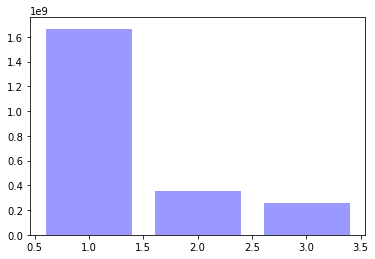

In [47]:
plt.bar([1,2,3], total_number_of_pixels_per_class, facecolor='#9999ff', edgecolor='white')

In [13]:
print(total_number_of_pixels_per_class)

[1672943358.0, 363715747.0, 261819487.0]


In [14]:
print(total_number_of_pixels_class_0/total_number_of_pixels_class_1)
print(total_number_of_pixels_class_0/total_number_of_pixels_class_2)
print(total_number_of_pixels_class_1/total_number_of_pixels_class_2)

4.599590124427579
6.389682361573033
1.389185164051597


In [15]:
#total_number_of_pixels_where_class_c_is_present = number_of_images * image_height * image_width # number of images * image_weight * image_width
#print(total_number_of_pixels_where_class_c_is_present)

[0.729452235884038, 0.19461974737141052, 0.13214388706167268]


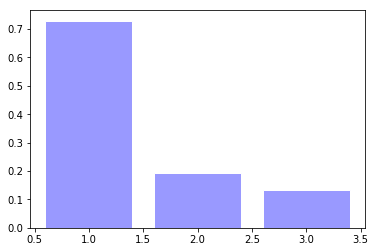

In [49]:
# weight for class 0 (Background)

# where freq(c) is the number of pixels of class c divided by the total number of pixels in images where c is present
freq_class_0 = total_number_of_pixels_class_0 / total_number_of_pixels_where_class_0_is_present
freq_class_1 = total_number_of_pixels_class_1 / total_number_of_pixels_where_class_1_is_present
freq_class_2 = total_number_of_pixels_class_2 / total_number_of_pixels_where_class_2_is_present
class_frequencies = [freq_class_0,freq_class_1,freq_class_2]
plt.bar([1,2,3], class_frequencies, facecolor='#9999ff', edgecolor='white')
print(class_frequencies)

In [50]:
# and median_freq is the median of all class frequencies. 
median_freq = np.median(class_frequencies)
print(median_freq)

0.194619747371


In [18]:
print("Weight class 0:", median_freq/freq_class_0)
print("Weight class 1:", median_freq/freq_class_1)
print("Weight class 2:", median_freq/freq_class_2)

Weight class 0: 0.266802592133
Weight class 1: 1.0
Weight class 2: 1.47278660935


In [53]:
# Should that be equall?
print(0.266802592133*total_number_of_pixels_class_0)
print(total_number_of_pixels_class_1)
print(1.47278660935*total_number_of_pixels_class_2)

446345624.40608543
363715747.0
385604234.5204864


In [ ]:
import tensorflow as tf
image = tf.Variable(tf.ones((64,64)))
sess = tf.Session()
cutout_shape = [24,24]

In [ ]:
sess.run(image.initializer)

In [ ]:
center_x = tf.cast(tf.random_uniform([1], maxval=tf.to_float(tf.shape(image)[0]))[0], dtype=tf.int32)
center_y = tf.cast(tf.random_uniform([1], maxval=tf.to_float(tf.shape(image)[1]))[0], dtype=tf.int32)

In [ ]:
sess.run([center_x, center_y])

In [ ]:
from_x = tf.cond(center_x - cutout_shape[0]//2 > 0, lambda:center_x-cutout_shape[0]//2, lambda:0)
to_x = tf.cond(center_x + cutout_shape[0]//2 > image.shape[0], lambda:image.shape[0], lambda:center_x+cutout_shape[0]//2)

In [ ]:
sess.run([to_x, from_x])

In [ ]:
from_y = tf.cond(center_y - cutout_shape[0]//2 > 0, lambda:center_y-cutout_shape[0]//2, lambda:0)
to_y = tf.cond(center_y + cutout_shape[0]//2 > image.shape[1], lambda:image.shape[1], lambda:center_y+cutout_shape[1]//2)

In [ ]:
sess.run([to_y, from_y])

In [ ]:
cutout = tf.zeros((to_x-from_x, to_y-from_y))
g = image[from_x:to_x,from_y:to_y].assign(cutout)

In [ ]:
img = sess.run(g)
img.shape

In [ ]:
plt.imshow(img.squeeze())
plt.show()

In [ ]:
def tf_cutout(input_image):
    cutout_shape = tf.constant([24,24])
    
    image = tf.get_variable("image_shape", shape=(64,64,3), initializer=tf.ones_initializer())
    sess.run(image.initializer)
    center_x = tf.cast(tf.random_uniform([1], maxval=tf.to_float(tf.shape(image)[0]))[0], dtype=tf.int32)
    center_y = tf.cast(tf.random_uniform([1], maxval=tf.to_float(tf.shape(image)[1]))[0], dtype=tf.int32)

    from_x = tf.cond(center_x - cutout_shape[0]//2 > 0, lambda:center_x-cutout_shape[0]//2, lambda:0)
    to_x = tf.cond(center_x + cutout_shape[0]//2 > tf.shape(image)[0], lambda:tf.shape(image)[0], lambda:center_x+cutout_shape[0]//2)

    from_y = tf.cond(center_y - cutout_shape[0]//2 > 0, lambda:center_y-cutout_shape[0]//2, lambda:0)
    to_y = tf.cond(center_y + cutout_shape[0]//2 > tf.shape(image)[1], lambda:tf.shape(image)[1], lambda:center_y+cutout_shape[1]//2)

    cutout_mask = tf.zeros((to_x-from_x, to_y-from_y,3), dtype=tf.float32)
    res = image[from_x:to_x,from_y:to_y].assign(cutout_mask)

    return tf.multiply(input_image, res)